In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data.csv')
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


Client has selected stores 77, 86, and 88 as trial stores and we want to establish control stores for each trial store. We would want to match trial stores to the control stores that are similar to the trial stores prior to the trial period of Feburary 2019 in terms of:
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

Let's first create the metrics of interest and filter to stores that are present throughout the pre-trial period.

## Selecting the control stores

In [5]:
# changing the date column into datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

In [6]:
df['month'] = df['DATE'].dt.to_period('M').dt.to_timestamp()

In [7]:
monthly = df.groupby(['STORE_NBR', 'month']).agg(
    {
        'TOT_SALES' : 'sum',
        'LYLTY_CARD_NBR': 'nunique',
        'TXN_ID' : 'nunique',
        'PROD_QTY': 'sum' 
    }
).reset_index()

In [8]:
monthly.rename(columns= {
    'TOT_SALES': 'sum_of_total_sales',
    'LYLTY_CARD_NBR': 'ncustomers',
    'TXN_ID' : 'ntransactions',
    'PROD_QTY': 'sum_product_qty'
}, inplace = True)

In [9]:
# let's create some metrics by using existing columns
monthly['nchips_per_trans'] = monthly['sum_product_qty'] / monthly['ntransactions']
monthly['avg_price_per_unit'] = monthly['sum_of_total_sales'] / monthly['sum_product_qty']
monthly['n_trans_per_customer'] = monthly['ntransactions'] / monthly['ncustomers']

In [10]:
monthly.head(3)

,STORE_NBR,month,sum_of_total_sales,ncustomers,ntransactions,sum_product_qty,nchips_per_trans,avg_price_per_unit,n_trans_per_customer
0,1,2018-07-01,206.9,49,52,62,1.192308,3.337097,1.061224
1,1,2018-08-01,176.1,42,43,54,1.255814,3.261111,1.023810
2,1,2018-09-01,278.8,59,62,75,1.209677,3.717333,1.050847


We need to filter this data and we need pre-trial data, all the data before the Feburary 2019 because this is the pre-trial period and the trial period is Feburary 2019 to April 2019.

We need to filter our dataset to the pre-trial period and stores with full observation periods. Here what is meant by stores with full observation periods? well it means the stores that have sale in every month before the trial period like any store shouldn't have any missing data in any month. Since, we have 7 months before the trial period so we need stores with sales in every month.

In [12]:
# filter to the data of pre-trial period
pre_trial = monthly[(monthly['month'] >= '2018-07-01') & (monthly['month'] <= '2019-01-31')]

In [13]:
# count how many unique months each store has in pre-trial period
store_month_counts = pre_trial.groupby('STORE_NBR')['month'].nunique().reset_index()
store_month_counts['month'].value_counts()

month
7    260
1      6
6      3
2      2
Name: count, dtype: int64

So we have 260 stores which are stores will full observations periods and remaning 11 stores have missing data in some of the months

In [15]:
# stores with full observation periods
store_month_counts = store_month_counts[store_month_counts['month'] == 7]
store_month_counts

,STORE_NBR,month
0,1,7
1,2,7
2,3,7
3,4,7
4,5,7
...,...,...
266,268,7
267,269,7
268,270,7
269,271,7


In [16]:
# keep only stores with full observations
full_stores = store_month_counts['STORE_NBR']

pre_trial_full = pre_trial[pre_trial['STORE_NBR'].isin(full_stores)]

In [17]:
pre_trial_full.head(3)

,STORE_NBR,month,sum_of_total_sales,ncustomers,ntransactions,sum_product_qty,nchips_per_trans,avg_price_per_unit,n_trans_per_customer
0,1,2018-07-01,206.9,49,52,62,1.192308,3.337097,1.061224
1,1,2018-08-01,176.1,42,43,54,1.255814,3.261111,1.023810
2,1,2018-09-01,278.8,59,62,75,1.209677,3.717333,1.050847


In [18]:
pre_trial_full.drop('sum_product_qty', axis = 1, inplace = True)

C:\Users\PMLS\AppData\Local\Temp\ipykernel_57420\2576910989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_trial_full.drop('sum_product_qty', axis = 1, inplace = True)


In [19]:
pre_trial_full.head()

,STORE_NBR,month,sum_of_total_sales,ncustomers,ntransactions,nchips_per_trans,avg_price_per_unit,n_trans_per_customer
0,1,2018-07-01,206.9,49,52,1.192308,3.337097,1.061224
1,1,2018-08-01,176.1,42,43,1.255814,3.261111,1.023810
2,1,2018-09-01,278.8,59,62,1.209677,3.717333,1.050847
3,1,2018-10-01,188.1,44,45,1.288889,3.243103,1.022727
4,1,2018-11-01,192.6,46,47,1.212766,3.378947,1.021739


Now we need to work out a way of ranking how similar each potential control store is to the trial store. We can calculate how correlated the performance of each store is to the trial store.

Let's write a function for this so we don't have to do it for each trial store and control store

In [21]:
def calculate_combined_correlations(pre_trial_df, trial_store, metric_cols):
    """
    Calculates average correlation of multiple metrics between a trial store and all other stores.

    Parameters:
    - pre_trial_df: DataFrame with pre-trial data (must include 'STORE_NBR', 'month', and metric columns)
    - trial_store: int, the store number of the trial store
    - metric_cols: list of str, names of the columns to compare (e.g., ['sum_of_total_sales', 'ntransactions'])

    Returns:
    - DataFrame with control_store and average correlation across selected metrics
    """

    # Get trial store data
    trial_data = pre_trial_df[pre_trial_df['STORE_NBR'] == trial_store][['month'] + metric_cols]
    trial_data = trial_data.sort_values('month').reset_index(drop=True)

    other_stores = pre_trial_df['STORE_NBR'].unique()
    other_stores = [store for store in other_stores if store != trial_store]

    result = []

    for store in other_stores:
        control_data = pre_trial_df[pre_trial_df['STORE_NBR'] == store][['month'] + metric_cols]
        control_data = control_data.sort_values('month').reset_index(drop=True)

        # Merge on 'month' to align time series
        merged = pd.merge(trial_data, control_data, on='month', how='inner', suffixes=('_trial', '_control'))

        # Calculate correlation per metric
        correlations = []
        for col in metric_cols:
            trial_col = f"{col}_trial"
            control_col = f"{col}_control"
            if merged[trial_col].isnull().any() or merged[control_col].isnull().any():
                continue
            corr = merged[trial_col].corr(merged[control_col])
            if pd.notnull(corr):
                correlations.append(corr)

        # Average correlation for this control store
        if correlations:
            avg_corr = sum(correlations) / len(correlations)
            result.append({'control_store': store, 'avg_corr': avg_corr})

    return pd.DataFrame(result).sort_values(by='avg_corr', ascending=False).reset_index(drop=True)

We will select control stores based on how similar they are to the trial stores based on how similar monthly total sales are and monthly number of customers are to the trial store.

In [23]:
metrics_to_compare = ['sum_of_total_sales', 'ncustomers']

# for trial store 77
combined_corr = calculate_combined_correlations(pre_trial_full, trial_store= 77, metric_cols= metrics_to_compare)
combined_corr.head()

,control_store,avg_corr
0,233,0.947066
1,119,0.925466
2,71,0.834461
3,3,0.820426
4,41,0.813726


We can see that store number 233 has the highest avg_corr of 0.94 so it means that **store 233 is the best control store** for the **trial store 77**. We will also see how the performance of this control store is to the trial store visually.

In [25]:
# for trial store 86
calculate_combined_correlations(pre_trial_full, trial_store= 86, metric_cols= metrics_to_compare)

,control_store,avg_corr
0,155,0.910379
1,114,0.794877
2,260,0.783426
3,109,0.779539
4,138,0.754782
...,...,...
254,270,-0.748973
255,185,-0.759336
256,108,-0.768829
257,120,-0.843895


**Control store 155** will be considered as the best control store for trial store 86

In [27]:
# for trial store 88
calculate_combined_correlations(pre_trial_full, trial_store = 88, metric_cols = metrics_to_compare)

,control_store,avg_corr
0,178,0.835661
1,14,0.820767
2,204,0.718018
3,134,0.686587
4,113,0.679198
...,...,...
254,48,-0.609324
255,141,-0.618994
256,227,-0.633695
257,239,-0.651501


**Control store 178** will be considered as the best control store for the **trial store 88**. We will still check the performance of each store to their respective trial store visually if the patterns of the performances are same or not but now we can say that these control stores might be the best control stores for the trial stores.

In [29]:
pre_trial_full.head(2)

,STORE_NBR,month,sum_of_total_sales,ncustomers,ntransactions,nchips_per_trans,avg_price_per_unit,n_trans_per_customer
0,1,2018-07-01,206.9,49,52,1.192308,3.337097,1.061224
1,1,2018-08-01,176.1,42,43,1.255814,3.261111,1.023810


### Visualization

**For control store 233 and trial store 77**

We will see that how the control store's pattern is to the trial store in the pre-trial period (before the trial, from July 2018 to Janurary 2019) in terms of the metrics; total sales by months and number of customers by month.

In [31]:
# trial store sales
trial_sales = pre_trial_full[pre_trial_full['STORE_NBR'] == 77][['month', 'sum_of_total_sales', 'ncustomers']]
trial_sales['store'] = 'Trial Store 77'

#control store sales
control_sales = pre_trial_full[pre_trial_full['STORE_NBR'] == 233][['month', 'sum_of_total_sales', 'ncustomers']]
control_sales['store'] = 'Control store 233'

# other stores sales
other_sales = pre_trial_full[(~pre_trial_full['STORE_NBR'].isin([77, 233]))].groupby('month').agg(
    {
        'sum_of_total_sales' : 'mean',
        'ncustomers' : 'mean'
    }
).reset_index()
other_sales['store'] = 'Other Stores Avg'

In [32]:
# combine into one df
combined_df = pd.concat([trial_sales, control_sales, other_sales], ignore_index= True)
combined_df.head(3)

,month,sum_of_total_sales,ncustomers,store
0,2018-07-01,296.8,51.0,Trial Store 77
1,2018-08-01,255.5,47.0,Trial Store 77
2,2018-09-01,225.2,42.0,Trial Store 77


In [33]:
# make a column month name
combined_df['month_name'] = combined_df['month'].dt.strftime('%b %Y')
combined_df.head()

,month,sum_of_total_sales,ncustomers,store,month_name
0,2018-07-01,296.8,51.0,Trial Store 77,Jul 2018
1,2018-08-01,255.5,47.0,Trial Store 77,Aug 2018
2,2018-09-01,225.2,42.0,Trial Store 77,Sep 2018
3,2018-10-01,204.5,37.0,Trial Store 77,Oct 2018
4,2018-11-01,245.3,41.0,Trial Store 77,Nov 2018


### Plot for comparing sales by months for stores 

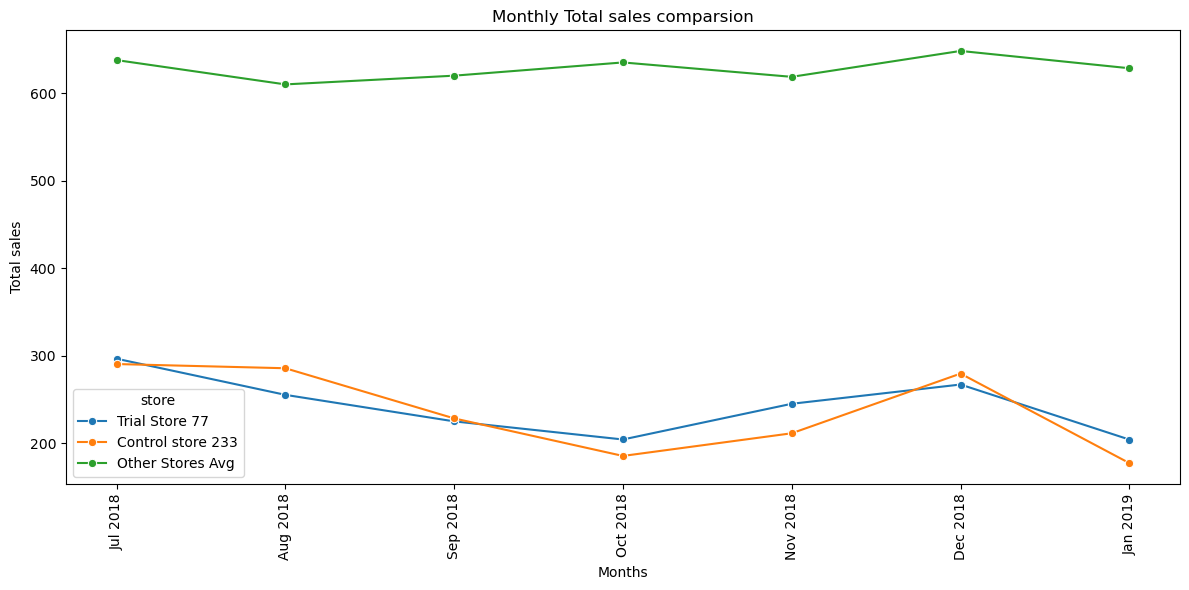

In [35]:
# plot of total sales and months for different stores including control and trial stores
plt.figure(figsize= (12,6))
sns.lineplot(data = combined_df, x = 'month_name', y = 'sum_of_total_sales', hue = 'store', marker = 'o')

plt.title('Monthly Total sales comparsion')
plt.xlabel('Months')
plt.ylabel('Total sales')
plt.xticks(rotation = 90)
plt.legend(title = 'store')
plt.tight_layout()
plt.show()

### Plot for comparing Number of customers by months

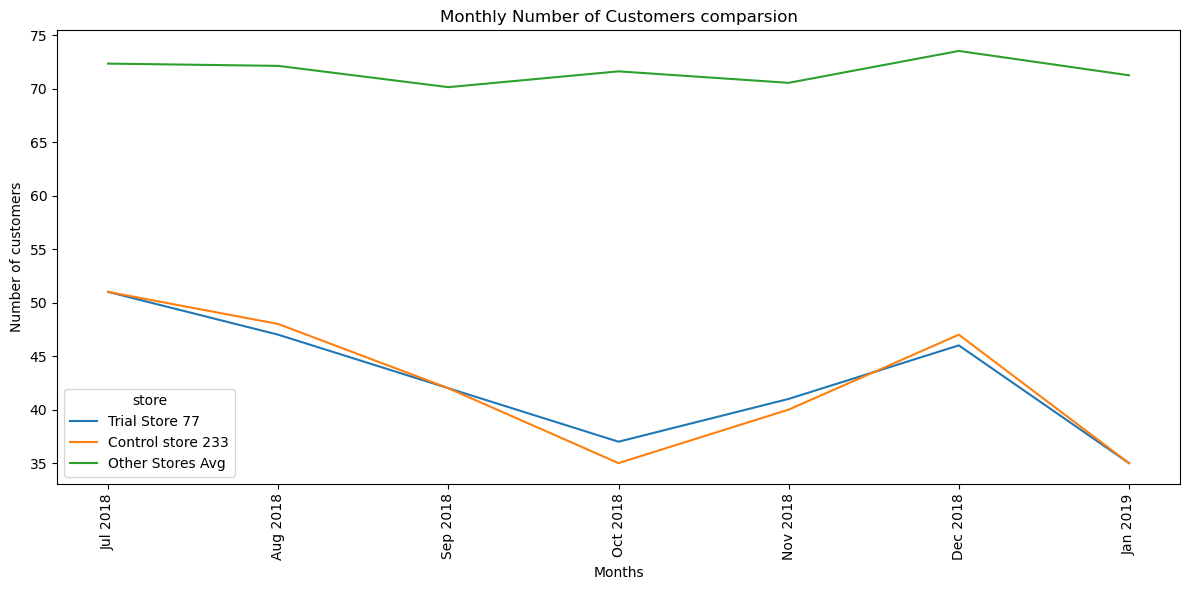

In [37]:
# plot for comparing number of customers 
plt.figure(figsize=(12,6))
sns.lineplot(data = combined_df, x = 'month_name', y = 'ncustomers', hue = 'store')

plt.title('Monthly Number of Customers comparsion')
plt.xlabel('Months')
plt.ylabel('Number of customers')
plt.xticks(rotation = 90)
plt.legend(title = 'store')
plt.tight_layout()
plt.show()

As we can see from the both plots that in plot 1, the pattern of sales of trial store and control store is approximately same and similarly the pattern and trend of number of customers by month is also approximately same for both stores in pre-trial period which indicates that control store 233 is best control store as compared to other stores for the trial store 77

___

### For trial store 86 and control store 155

Instead of doing doing the same code above we will simply make two functions. One for plotting lineplot of the sales comparsion by months and one for plotting line plot for number of customers by months.

In [41]:
def plot_total_sales(pre_trial_df, trial_store, control_store, save = False):
    """
    Plots total sales over time for trial store, control store, and average of other stores.
    """
    # Trial store
    trial_sales = pre_trial_df[pre_trial_df['STORE_NBR'] == trial_store][['month', 'sum_of_total_sales']].copy()
    trial_sales['Store'] = f'Trial Store {trial_store}'

    # Control store
    control_sales = pre_trial_df[pre_trial_df['STORE_NBR'] == control_store][['month', 'sum_of_total_sales']].copy()
    control_sales['Store'] = f'Control Store {control_store}'

    # Other stores
    other_sales = pre_trial_df[
        ~pre_trial_df['STORE_NBR'].isin([trial_store, control_store])
    ].groupby('month')['sum_of_total_sales'].mean().reset_index()
    other_sales['Store'] = 'Other Stores Avg'

    # Combine
    combined = pd.concat([trial_sales, control_sales, other_sales])
    combined['month'] = pd.to_datetime(combined['month'])
    combined['month_name'] = combined['month'].dt.strftime('%b %Y')

    # Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=combined, x='month_name', y='sum_of_total_sales', hue='Store', marker='o')
    plt.title(f'Monthly Total Sales: Trial Store {trial_store} vs Control Store {control_store}')
    plt.xlabel('Month')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)
    plt.legend(title='Store')
    plt.tight_layout()
    if save:
        filename = f"trial_store_{trial_store}_and_control_store_{control_store}_sales.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [42]:
def plot_customer_counts(pre_trial_df, trial_store, control_store, save = False):
    """
    Plots number of customers over time for trial store, control store, and average of other stores.
    """
    # Trial store
    trial_customers = pre_trial_df[pre_trial_df['STORE_NBR'] == trial_store][['month', 'ncustomers']].copy()
    trial_customers['Store'] = f'Trial Store {trial_store}'

    # Control store
    control_customers = pre_trial_df[pre_trial_df['STORE_NBR'] == control_store][['month', 'ncustomers']].copy()
    control_customers['Store'] = f'Control Store {control_store}'

    # Other stores
    other_customers = pre_trial_df[
        ~pre_trial_df['STORE_NBR'].isin([trial_store, control_store])
    ].groupby('month')['ncustomers'].mean().reset_index()
    other_customers['Store'] = 'Other Stores Avg'

    # Combine
    combined = pd.concat([trial_customers, control_customers, other_customers])
    combined['month'] = pd.to_datetime(combined['month'])
    combined['month_name'] = combined['month'].dt.strftime('%b %Y')

    # Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=combined, x='month_name', y='ncustomers', hue='Store', marker='o')
    plt.title(f'Monthly Number of Customers: Trial Store {trial_store} vs Control Store {control_store}')
    plt.xlabel('Month')
    plt.ylabel('Number of Customers')
    plt.xticks(rotation=45)
    plt.legend(title='Store')
    plt.tight_layout()
    if save:
        filename = f"trial_store_{trial_store}_and_control_store_{control_store}_customers.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

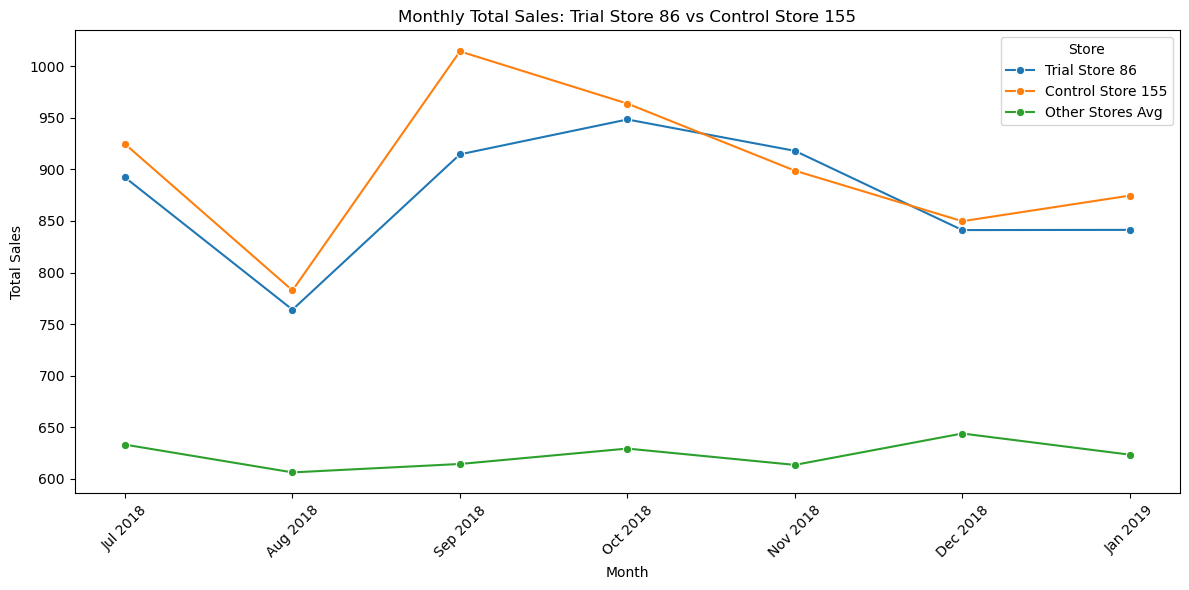

In [43]:
# total sales plot for trial store 86 and control store 155 and other stores
plot_total_sales(pre_trial_full, trial_store= 86, control_store= 155)

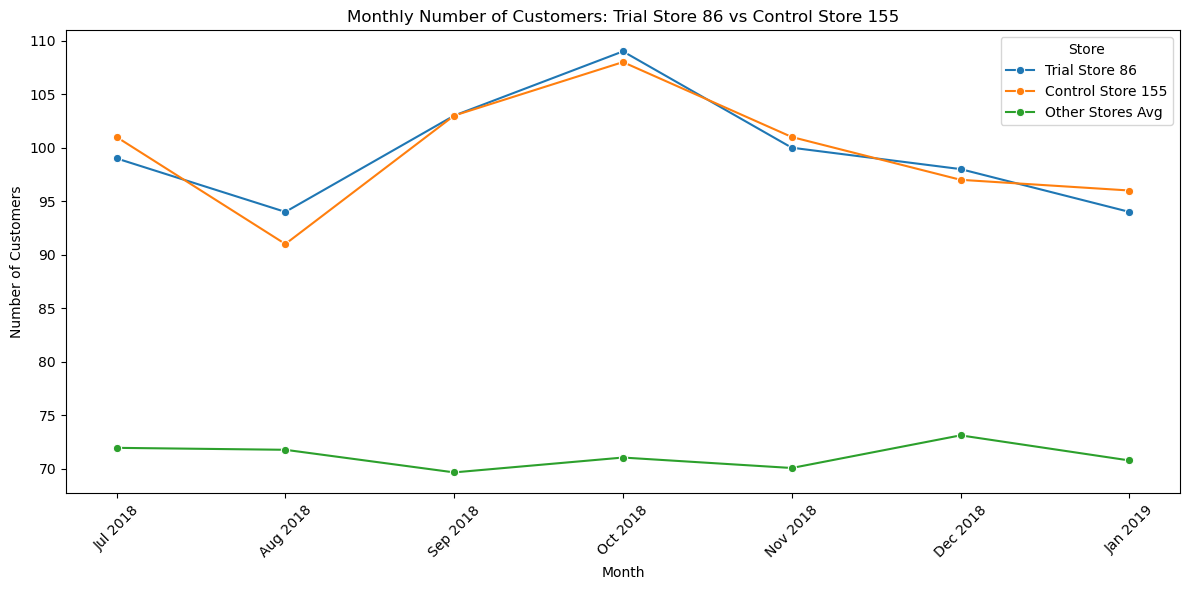

In [44]:
# plot for comparing number of customers by month
plot_customer_counts(pre_trial_full, trial_store= 86, control_store= 155)

In the both plots we can see that the trend of lines over the time period is very same. Hence, control store 155 is the best control store for the trial store 86

### For trial store 88 and control store 178

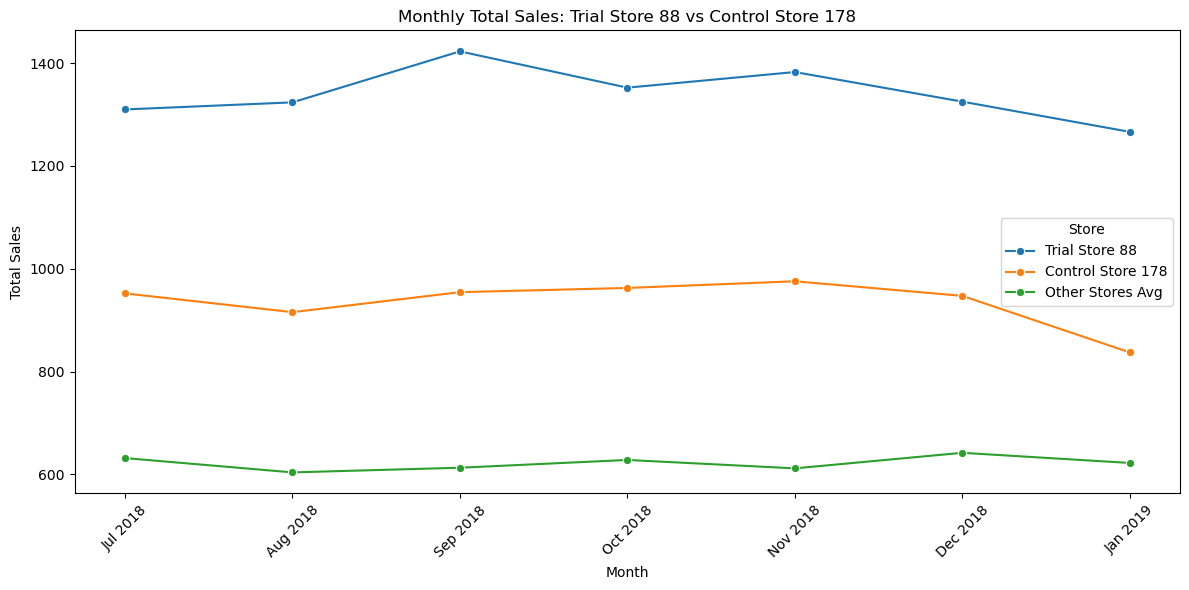

In [47]:
# plot of total sales by months
plot_total_sales(pre_trial_full, trial_store= 88, control_store= 178)

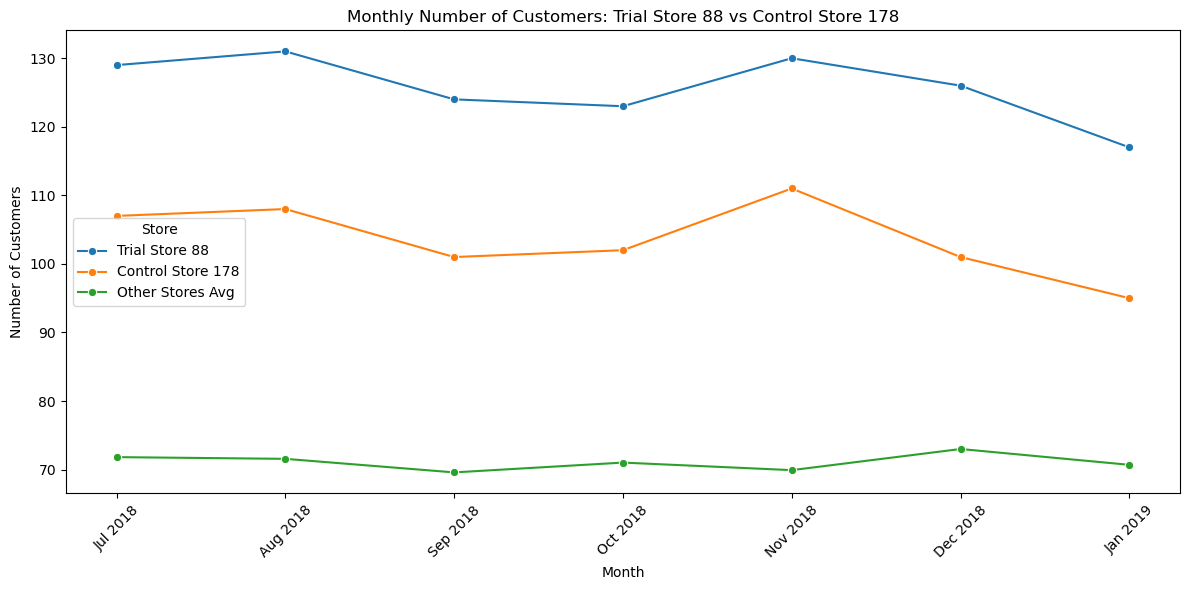

In [48]:
# plot for comparing number of customers by month
plot_customer_counts(pre_trial_full, trial_store= 88, control_store= 178)

Here we have problem we can see that in both plots there is a big difference in magnitude of values for trial store 88 and control store 178. So we need to select any other control store for this trial store 88.

Since, we used the correlation method and it only tells the similarity but not the scales of the variables. In other words,  if we say that one variable increases and other also tends to increase then it means they have strong correlation but it doesn't mean that they would also be same in magnitude.

So how can we choose the best control store for the trial store 88? well,  we can do two things, First we can check visually the top 3 stores which we obtained above by correlation method if any of them has the similar shape and similar scale. Second thing which we can do is that we can create a function which will rank the stores by considering both correlation and magnitude distance (difference) which is basically combined similarity metric considering both trend and scale.

We will simply jump to the second method and will descibe a function
___

In [50]:
# function for ranking stores by combined score of magnitude difference and correlation score
def rank_control_stores(pre_trial_df, trial_store, metric_col, correlation_weight=0.5, magnitude_weight=0.5):
    """
    Ranks control stores for a given trial store based on trend (correlation) and magnitude similarity.

    Parameters:
        pre_trial_df (DataFrame): DataFrame with monthly store data
        trial_store (int): store number of trial store
        metric_col (str): column name of metric to compare (e.g., 'sum_of_total_sales')
        correlation_weight (float): weight of correlation in score (default 0.5)
        magnitude_weight (float): weight of magnitude distance in score (default 0.5)

    Returns:
        DataFrame with store numbers, correlation, magnitude_diff, and combined score
    """
    scores = []
    
    # Get the metric time series of the trial store
    trial_series = pre_trial_df[pre_trial_df['STORE_NBR'] == trial_store].sort_values('month')[metric_col].values
    
    # List of other stores
    other_stores = pre_trial_df['STORE_NBR'].unique()
    other_stores = other_stores[other_stores != trial_store]

    for store in other_stores:
        store_series = pre_trial_df[pre_trial_df['STORE_NBR'] == store].sort_values('month')[metric_col].values
        
        # Skip stores with missing data
        if len(store_series) != len(trial_series):
            continue

        # Trend similarity (correlation)
        corr = np.corrcoef(trial_series, store_series)[0, 1]

        # Magnitude similarity (mean absolute percentage difference)
        mag_diff = np.mean(np.abs(trial_series - store_series) / (trial_series + 1e-9))  # avoid div by zero

        # Normalize magnitude to 0-1 scale (smaller is better, so we invert)
        mag_score = 1 - mag_diff  # higher is better now

        # Combine both
        final_score = (correlation_weight * corr) + (magnitude_weight * mag_score)

        scores.append({
            'control_store': store,
            'correlation': round(corr, 4),
            'magnitude_similarity': round(mag_score, 4),
            'combined_score': round(final_score, 4)
        })

    score_df = pd.DataFrame(scores)
    score_df = score_df.sort_values(by='combined_score', ascending=False).reset_index(drop=True)

    return score_df

In [51]:
# for trial store 88
metrics = ['sum_of_total_sales', 'ncustomers']
rank_control_stores(pre_trial_full, trial_store= 88, metric_col= metrics)

,control_store,correlation,magnitude_similarity,combined_score
0,237,1.0,0.9720,0.9860
1,203,1.0,0.9475,0.9738
2,40,1.0,0.9404,0.9702
3,199,1.0,0.9278,0.9639
4,165,1.0,0.9246,0.9623
...,...,...,...,...
254,244,1.0,0.0273,0.5136
255,146,1.0,0.0256,0.5128
256,258,1.0,0.0254,0.5127
257,198,1.0,0.0230,0.5115


By looking at combined score we can see that store number 237 is the best control store for trial store 88. Let's check the trends and patterns graphically.

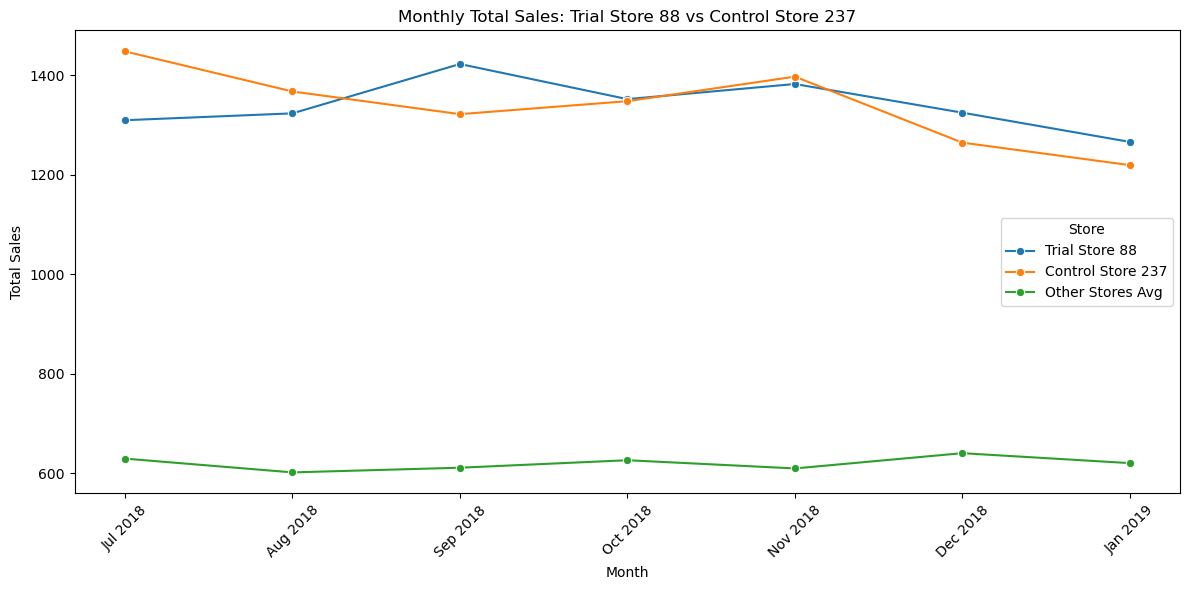

In [53]:
plot_total_sales(pre_trial_full, trial_store= 88, control_store= 237)

The trend of line is approximately same for total sales of months for both stores and difference of magnitude of values is also very same.

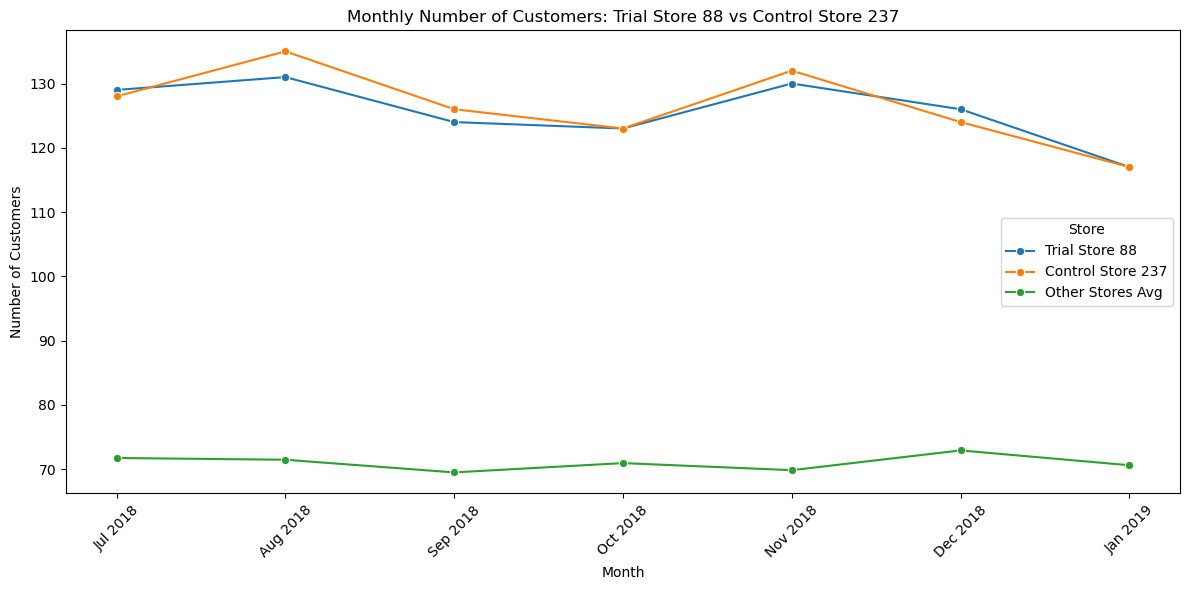

In [55]:
plot_customer_counts(pre_trial_full, trial_store = 88, control_store = 237)

This graph also looks good for both stores. Hence  **control store 237** is the best control store for the **trial store 88**.

So control stores 233, 155, and 237 are the best control stores for trial stores 77, 86, and 88 respectively.

## Assessment of trial

In the assessment of trial, the purpose is to evaluate whether trial intervention (run in trial stores 77, 86, and 88) had statistically significant postive impact on chips sales and customer numbers.

We need to test if the trial caused an uplift in chips sales and/or customer counts by comparing the trial store's performance to it's corresponding control store's performance during the trial period (From the start of Feburary 2019 to end of April  2019)

## Scale control store to match trial store pre-trial levels

Scaling the control stores is important to make sure that we are comparing apples with apples. One store might be bigger than the other. We can understand the scaling concept by an example. Let's suppose that the control store 233 had monthly pre-trial sales around `$700` and trial store 77 had monthly pre-trial sales around `$1000`. So trial store is bigger than the control store and we cannot compare them because it would always look like that trial store always perform better than control store while both stores grow at the same %. SO we compute scaling factor by dividing 1000/700 = 1.5 which is scaling factor and it will be multiplied by all control store sales to bring them up as same level as trial store sales

**NOTE:** We will compute scaling factor by using pre-trial data and then we will apply it to the control store in the pre-trail period and trial period as well

#### For trial store 77 and control store 233

##### 1 - Scaling control store sales

In [61]:
# get total sales for pre-trial period
trial_store = 77
control_store = 233

trial_sales = pre_trial_full[pre_trial_full['STORE_NBR'] == trial_store]['sum_of_total_sales'].sum()
control_sales = pre_trial_full[pre_trial_full['STORE_NBR'] == control_store]['sum_of_total_sales'].sum()

# scaling factor
scaling_factor = trial_sales / control_sales
scaling_factor

# apply scaling factor to the control store
monthly.loc[monthly['STORE_NBR'] == control_store, 'scaled_sales'] = (
    monthly.loc[monthly['STORE_NBR'] == control_store, 'sum_of_total_sales'] * scaling_factor
)

##### 2 - calculate % difference between trial and control in trial period

After scaling, we want to check how much the trial store's sales differ from the scaled sales of control store month by month in the trial period (Feb 2019 - Apr 2019)

In [63]:
# filter to the data of trial period and pre_trial_df
trial_period = monthly[(monthly['month'] >= '2019-02-01') & (monthly['month'] <= '2019-04-30')]
pre_trial_updated = monthly[(monthly['month'] >= '2018-07-01') & (monthly['month'] <= '2019-01-31')]

# select relevant data
trial_sales = trial_period[trial_period['STORE_NBR'] == trial_store][['month', 'sum_of_total_sales']]
control_sales = trial_period[trial_period['STORE_NBR'] == control_store][['month', 'scaled_sales']]

# merge both datasets on month
comparsion = pd.merge(trial_sales, control_sales, on = 'month')

# calculate % difference
comparsion['perc_diff'] = abs(comparsion['sum_of_total_sales'] - comparsion['scaled_sales']) / comparsion['scaled_sales']
comparsion

,month,sum_of_total_sales,scaled_sales,perc_diff
0,2019-02-01,235.0,249.762622,0.059107
1,2019-03-01,278.5,203.802205,0.366521
2,2019-04-01,263.5,162.345704,0.623080


`perc_difference` tells us how far the trial store is from control store in each month. For example, in the month of february, perc_diff = 0.05 which means that trial store was 5% higher or lower than expected.

In [65]:
# calculate standard deviation of % difference in pre-trial
pre_trial_trial = pre_trial_updated[pre_trial_updated['STORE_NBR'] ==  trial_store][['month', 'sum_of_total_sales']]
pre_trial_control = pre_trial_updated[pre_trial_updated['STORE_NBR'] ==  control_store][['month', 'scaled_sales']]

# combine both
pre_comparsion = pd.merge(pre_trial_trial, pre_trial_control)

# calculate percentage difference
pre_comparsion['%_diff'] = abs(pre_comparsion['sum_of_total_sales'] - pre_comparsion['scaled_sales']) / pre_comparsion['scaled_sales']

# calculate standard deviation of % difference
std = pre_comparsion['%_diff'].std()

In [66]:
# let's compute crtical value of t with (pre-trial months - 1) = 7 degrees of freedom and 0.05 level of significance
from scipy.stats import t
t_critical = t.ppf(0.95, df = 7)
t_critical

1.894578605061305

In [67]:
# null hypothesis: No difference (mean difference = 0 )
from scipy import stats
comparsion['t_statistic'] = (comparsion['perc_diff'] - 0) / std

# significant column
comparsion['significant'] = comparsion['t_statistic'] > t_critical
comparsion['p_value'] = 1 - stats.t.cdf(comparsion['t_statistic'], 7)
comparsion

,month,sum_of_total_sales,scaled_sales,perc_diff,t_statistic,significant,p_value
0,2019-02-01,235.0,249.762622,0.059107,1.183534,False,0.137614
1,2019-03-01,278.5,203.802205,0.366521,7.339116,True,0.000079
2,2019-04-01,263.5,162.345704,0.623080,12.476373,True,0.000002


So we can see that sales in the trial store 77 in the months of March and April were statistically significant which indicates that trial had a significant impact in March and April It means that there is an uplift in the sales in the trial stores as compared to the control store. On the other hand the sales in trial store were not statistically significant in month February.

- Overall, the trial was successful. March and April show a statistically significant uplift in the total sales for trial store which means trial was effective.
- February had a small non-significant impact possibly due to delayed impact (time needed for customer adaption etc.)
___

Let's have a look at accessing this for number of customers as well.

In [70]:
pre_trial_full.head(1)

,STORE_NBR,month,sum_of_total_sales,ncustomers,ntransactions,nchips_per_trans,avg_price_per_unit,n_trans_per_customer
0,1,2018-07-01,206.9,49,52,1.192308,3.337097,1.061224


In [71]:
# we will be repeating all the steps as we did for sales
# get total sales for pre-trial period
trial_store = 77
control_store = 233

trial_ncustomers = pre_trial_full[pre_trial_full['STORE_NBR'] == trial_store]['ncustomers'].sum()
control_ncustomers = pre_trial_full[pre_trial_full['STORE_NBR'] == control_store]['ncustomers'].sum()

# scaling factor
scaling_factor_cust = trial_ncustomers / control_ncustomers
scaling_factor_cust

# apply scaling factor to the control store
monthly_copy = monthly.copy()
monthly_copy.loc[monthly_copy['STORE_NBR'] == control_store, 'control_customers'] = (
    monthly_copy.loc[monthly_copy['STORE_NBR'] == control_store, 'ncustomers'] * scaling_factor_cust
)
monthly_copy.head()

,STORE_NBR,month,sum_of_total_sales,ncustomers,ntransactions,sum_product_qty,nchips_per_trans,avg_price_per_unit,n_trans_per_customer,scaled_sales,control_customers
0,1,2018-07-01,206.9,49,52,62,1.192308,3.337097,1.061224,NaN,NaN
1,1,2018-08-01,176.1,42,43,54,1.255814,3.261111,1.023810,NaN,NaN
2,1,2018-09-01,278.8,59,62,75,1.209677,3.717333,1.050847,NaN,NaN
3,1,2018-10-01,188.1,44,45,58,1.288889,3.243103,1.022727,NaN,NaN
4,1,2018-11-01,192.6,46,47,57,1.212766,3.378947,1.021739,NaN,NaN


In [72]:
# filter to the data of trial period and pre_trial_df
trial_period_df = monthly_copy[(monthly_copy['month'] >= '2019-02-01') & (monthly_copy['month'] <= '2019-04-30')]
pre_trial_updated_df = monthly_copy[(monthly_copy['month'] >= '2018-07-01') & (monthly_copy['month'] <= '2019-01-31')]

# select relevant data
trial_ncustomers = trial_period_df[trial_period_df['STORE_NBR'] == trial_store][['month', 'ncustomers']]
control_ncustomers = trial_period_df[trial_period_df['STORE_NBR'] == control_store][['month', 'control_customers']]

# merge both datasets on month
comparsion_ncustomers = pd.merge(trial_ncustomers, control_ncustomers, on = 'month')
comparsion_ncustomers

# compute percentage difference
comparsion_ncustomers['perc_diff'] = abs(comparsion_ncustomers['control_customers'] - comparsion_ncustomers['ncustomers']) / comparsion_ncustomers['control_customers']
comparsion_ncustomers

,month,ncustomers,control_customers,perc_diff
0,2019-02-01,45,45.151007,0.003344
1,2019-03-01,50,40.134228,0.245819
2,2019-04-01,47,30.100671,0.561427


In [73]:
pre_trial_updated_df.head(2)

,STORE_NBR,month,sum_of_total_sales,ncustomers,ntransactions,sum_product_qty,nchips_per_trans,avg_price_per_unit,n_trans_per_customer,scaled_sales,control_customers
0,1,2018-07-01,206.9,49,52,62,1.192308,3.337097,1.061224,NaN,NaN
1,1,2018-08-01,176.1,42,43,54,1.255814,3.261111,1.023810,NaN,NaN


In [74]:
# calculate standard deviation of % difference in pre-trial period
pre_trial_trial_df = pre_trial_updated_df[pre_trial_updated_df['STORE_NBR'] ==  trial_store][['month', 'ncustomers']]
pre_trial_control_df = pre_trial_updated_df[pre_trial_updated_df['STORE_NBR'] ==  control_store][['month', 'control_customers']]

# combine both
pre_comparsion_cust = pd.merge(pre_trial_trial_df, pre_trial_control_df)

# calculate percentage difference
pre_comparsion_cust['%_diff'] = abs(pre_comparsion_cust['ncustomers'] - pre_comparsion_cust['control_customers']) / pre_comparsion_cust['control_customers']

# calculate standard deviation of % difference
standard_dev = pre_comparsion_cust['%_diff'].std()

The critical value of t distribution would be same with 7 degrees of freedom and 0.05 level of significance

In [76]:
# Null hypothesis : No difference (mean difference = 0)
# Alternate hypothesis : Mean difference > 0
from scipy import stats
comparsion_ncustomers['t_stats'] = (comparsion_ncustomers['perc_diff'] - 0) / standard_dev
comparsion_ncustomers['significant'] = comparsion_ncustomers['t_stats'] > t_critical
comparsion_ncustomers['p_value'] = 1 - stats.t.cdf(comparsion_ncustomers['t_stats'], 7)
comparsion_ncustomers

,month,ncustomers,control_customers,perc_diff,t_stats,significant,p_value
0,2019-02-01,45,45.151007,0.003344,0.183352,False,4.298597e-01
1,2019-03-01,50,40.134228,0.245819,13.476388,True,1.454160e-06
2,2019-04-01,47,30.100671,0.561427,30.778725,True,4.932226e-09


In the month of February, the trial was not statistically significant in trial store 77 and there is not significant impact on uplift in number of customers as compared to number of customers in it's control store. In the months of March and April,  the trial was successful and had a statistically significant impact on the number of customers and results in uplift in the number of customers.

So Overall the trial was successful which was run in trial store 77 and had a significant impact on number of customers.

___

Now we need to do the same work exactly for trial stores 86 and 88 and need to compare the trial's performance by it's control stores by the statistical analysis as we did above. But doing the same lines of code would consume so much time so instead we can make a function, a function which can return the comparsion dataframe for the number of customers and for the sales comparsion. So we will be making two functions.

In [79]:
# function for making sales comparsion for trial store corresponding to it's control store

def compare_sales(monthly_df, trial_store, control_store, pre_trial_end='2019-01-31', trial_start='2019-02-01', trial_end='2019-04-30'):
    # Filter pre-trial data
    pre_trial = monthly_df[monthly_df['month'] <= pre_trial_end]

    # Calculate scaling factor
    trial_pre_sales = pre_trial[pre_trial['STORE_NBR'] == trial_store]['sum_of_total_sales'].sum()
    control_pre_sales = pre_trial[pre_trial['STORE_NBR'] == control_store]['sum_of_total_sales'].sum()
    scaling_factor = trial_pre_sales / control_pre_sales

 # Apply scaling
# Make a copy of the original DataFrame to avoid modifying it
    monthly_df_copy = monthly_df.copy()

# Create a new column 'scaled_sales' and apply scaling ONLY to control store rows
    monthly_df_copy.loc[monthly_df_copy['STORE_NBR'] == control_store, 'scaled_sales'] = (
    monthly_df_copy.loc[monthly_df_copy['STORE_NBR'] == control_store, 'sum_of_total_sales'] * scaling_factor
)


    # Filter for trial period
    trial = monthly_df_copy[(monthly_df_copy['month'] >= trial_start) & (monthly_df_copy['month'] <= trial_end)]
    trial_data = trial[trial['STORE_NBR'] == trial_store][['month', 'sum_of_total_sales']]
    control_data = trial[trial['STORE_NBR'] == control_store][['month', 'scaled_sales']]

    # Merge trial and control sales
    comp = pd.merge(trial_data, control_data, on='month')
    comp['perc_diff'] = abs(comp['sum_of_total_sales'] - comp['scaled_sales']) / comp['scaled_sales']

    # Calculate std deviation from pre-trial percentage differences
    trial_pre = pre_trial[pre_trial['STORE_NBR'] == trial_store][['month', 'sum_of_total_sales']]
    control_pre = pre_trial[pre_trial['STORE_NBR'] == control_store][['month', 'sum_of_total_sales']]
    control_pre['scaled_sales'] = control_pre['sum_of_total_sales'] * scaling_factor
    pre_comp = pd.merge(trial_pre, control_pre[['month', 'scaled_sales']], on='month')
    pre_comp['perc_diff'] = abs(pre_comp['sum_of_total_sales'] - pre_comp['scaled_sales']) / pre_comp['scaled_sales']
    std_dev = pre_comp['perc_diff'].std()

    # Compute t-stats and significance
    comp['t_statistic'] = comp['perc_diff'] / std_dev
    t_critical = t.ppf(0.95, df=len(pre_comp) - 1)
    comp['significant'] = comp['t_statistic'] > t_critical
    comp['p_value'] = 1 - stats.t.cdf(comp['t_statistic'], 7)

    return comp

In [80]:
# function for comparing customers of trial stores with it's control store
from scipy import stats
def compare_customers(monthly_df, trial_store, control_store, pre_trial_end='2019-01-31', trial_start='2019-02-01', trial_end='2019-04-30'):
    # Filter pre-trial data
    pre_trial = monthly_df[monthly_df['month'] <= pre_trial_end]

    # Calculate scaling factor
    trial_pre_customers = pre_trial[pre_trial['STORE_NBR'] == trial_store]['ncustomers'].sum()
    control_pre_customers = pre_trial[pre_trial['STORE_NBR'] == control_store]['ncustomers'].sum()
    scaling_factor = trial_pre_customers / control_pre_customers

    # Apply scaling
    monthly_copy = monthly_df.copy()
    monthly_copy.loc[monthly_copy['STORE_NBR'] == control_store, 'control_customers'] = (
    monthly_copy.loc[monthly_copy['STORE_NBR'] == control_store, 'ncustomers'] * scaling_factor
)

    # Filter trial period
    trial = monthly_copy[(monthly_copy['month'] >= trial_start) & (monthly_copy['month'] <= trial_end)]
    trial_data = trial[trial['STORE_NBR'] == trial_store][['month', 'ncustomers']].rename(columns={'ncustomers': 'sum_of_customers'})
    control_data = trial[trial['STORE_NBR'] == control_store][['month', 'control_customers']]

    # Merge
    comp = pd.merge(trial_data, control_data, on='month')
    comp['perc_diff'] = (comp['sum_of_customers'] - comp['control_customers']) / comp['control_customers']

    # Std dev from pre-trial
    trial_pre = pre_trial[pre_trial['STORE_NBR'] == trial_store][['month', 'ncustomers']]
    control_pre = pre_trial[pre_trial['STORE_NBR'] == control_store][['month', 'ncustomers']]
    control_pre['scaled_customers'] = control_pre['ncustomers'] * scaling_factor
    pre_comp = pd.merge(trial_pre, control_pre[['month', 'scaled_customers']], on='month')
    pre_comp['perc_diff'] = abs(pre_comp['ncustomers'] - pre_comp['scaled_customers']) / pre_comp['scaled_customers']
    std_dev = pre_comp['perc_diff'].std()

    # t-values
    comp['t_statistic'] = comp['perc_diff'] / std_dev
    t_critical = t.ppf(0.95, df=len(pre_comp) - 1)
    comp['significant'] = comp['t_statistic'] > t_critical
    comp['p_value'] = 1 - stats.t.cdf(comp['t_statistic'], 7)

    return comp

### For trial store 86 and control store 155

In [82]:
# comparing sales 
compare_sales(monthly, trial_store = 86, control_store = 155)

,month,sum_of_total_sales,scaled_sales,perc_diff,t_statistic,significant,p_value
0,2019-02-01,913.2,864.522060,0.056306,2.179542,True,0.032843
1,2019-03-01,1026.8,780.320405,0.315870,12.226922,True,0.000003
2,2019-04-01,848.2,819.317024,0.035253,1.364580,False,0.107314


In [83]:
compare_customers(monthly, trial_store = 86, control_store = 155)

,month,sum_of_customers,control_customers,perc_diff,t_statistic,significant,p_value
0,2019-02-01,107,95.0,0.126316,11.819082,True,3.520152e-06
1,2019-03-01,115,94.0,0.223404,20.903430,True,7.206844e-08
2,2019-04-01,105,99.0,0.060606,5.670772,True,3.789745e-04


**Sales Comparsion**

- **February:** There is moderate uplift in sales and is statistically significant
- **March:** Strong uplift in trial store sales and very statistically significant
- **April:** April sales are slightly higher but not Statistically significant

Overall, the trial seems to have had a positive impact on sales in february and strong impact in March but in April it did not have much impact on sales maybe due to some factors.

**Customers Comparsion**
- The trial was statistially significant across all 3 months.
- For all three months, the number of customers in trial stores is significantly higher than the number of customers in the control stores.
- Even in the month of April, where sales were not significantly higher but the customers count was.

The trial was successful and effective in bringing more customers throughout the trial period - even in the month of April.
___

### For trial store 88  and control store 237

In [86]:
# comparing sales 
compare_sales(monthly, trial_store = 88, control_store = 237)

,month,sum_of_total_sales,scaled_sales,perc_diff,t_statistic,significant,p_value
0,2019-02-01,1370.2,1406.989143,0.026147,0.781270,False,0.230123
1,2019-03-01,1477.2,1210.082775,0.220743,6.595668,True,0.000153
2,2019-04-01,1439.4,1206.477165,0.193060,5.768527,True,0.000343


In [87]:
# comparing customers 
compare_customers(monthly, trial_store = 86, control_store = 155)

,month,sum_of_customers,control_customers,perc_diff,t_statistic,significant,p_value
0,2019-02-01,107,95.0,0.126316,11.819082,True,3.520152e-06
1,2019-03-01,115,94.0,0.223404,20.903430,True,7.206844e-08
2,2019-04-01,105,99.0,0.060606,5.670772,True,3.789745e-04


**Sales Comparsion**

- **February:** There is not an uplift in sales and is not statistically significant
- **March:** Strong uplift in trial store sales and statistically significant
- **April:** April sales are also higher than the control sales and are statistically significant

Overall, the trial seems to have had a positive impact on sales in trial store 88 in the months March and April and had an uplift in sales but in the month of February, the sales are not statistically significant and lower than the control store's sales due to some factors like customer adaption, time implementation etc.

**Customers Comparsion**
- The trial was statistially significant across all 3 months.
- For all three months, the number of customers in trial stores is significantly higher than the number of customers in the control stores.
- Even in the month of February, where sales were not significantly higher but the customers count was.

The trial was successful and effective in bringing more customers throughout the trial period - even in the month of February.

One thing to notice that more customers doesn't mean more sales. As we have seen in our analysis that the trial which was conducted on trial store 86 didn't have a positive impact on sales in April but the number of customers was statistically significant in April which indicates that more customers in month doesn't necessarily mean more significant impact on monthly sales. By more customers, we can have more sales in some cases but it might not be significant.
___

### Conclusion

Overall, trial shows significant increase in sales and the trial was effective in all trial stores and was effective in in the monthly sales for at least 2 of the 3 trial months. Client should check the factors in those months where the sales were not statistically significant. The trial was also effective in increasing the number of customers overall for all trial stores. 

___